### 1. Denoising Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(32)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(64)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(128)

        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(256)

        # Decoder
        self.decoder_conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(128)
        self.decoder_conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(64)
        self.decoder_conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.decoder_bn3 = nn.BatchNorm2d(32)
        self.output_conv = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = F.max_pool2d(x, 2, 2) # Downsample by 2
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = F.max_pool2d(x, 2, 2) # Downsample by 2
        x = F.relu(self.encoder_bn3(self.encoder_conv3(x)))
        x = F.max_pool2d(x, 2, 2) # Downsample by 2

        # Bottleneck
        x = F.relu(self.bottleneck_bn(self.bottleneck_conv(x)))

        # Decoder
        x = F.interpolate(x, scale_factor=2, mode='nearest') # Upsample by 2
        x = F.relu(self.decoder_bn1(self.decoder_conv1(x)))
        x = F.interpolate(x, scale_factor=2, mode='nearest') # Upsample by 2
        x = F.relu(self.decoder_bn2(self.decoder_conv2(x)))
        x = F.interpolate(x, scale_factor=2, mode='nearest') # Upsample by 2
        x = F.relu(self.decoder_bn3(self.decoder_conv3(x)))

        # Output
        x = self.output_conv(x)
        return x

print("DenoisingNet class defined.")

DenoisingNet class defined.


### 2. Noise Generation Functions

In [ ]:
import torch
import numpy as np

def add_gaussian_noise(image_tensor, std):
    """
    Adds Gaussian noise to an image tensor.

    Args:
        image_tensor (torch.Tensor): The clean image tensor (C, H, W).
        std (float): Standard deviation of the Gaussian noise.

    Returns:
        torch.Tensor: Noisy image tensor with Gaussian noise.
    """
    noise = torch.randn_like(image_tensor) * std
    noisy_image = image_tensor + noise
    return torch.clamp(noisy_image, 0., 1.)

print("add_gaussian_noise function defined.")

add_gaussian_noise function defined.


In [ ]:
def add_impulse_noise(image_tensor, ratio):
    """
    Adds impulse noise (salt-and-pepper) to an image tensor.

    Args:
        image_tensor (torch.Tensor): The clean image tensor (C, H, W).
        ratio (float): The ratio of pixels to be affected by impulse noise.

    Returns:
        torch.Tensor: Noisy image tensor with impulse noise.
    """
    noisy_image = image_tensor.clone()
    num_pixels = image_tensor.numel() // image_tensor.shape[0] # H * W
    num_noise_pixels = int(num_pixels * ratio)

    # Generate random indices for noise
    idx = torch.randperm(num_pixels)[:num_noise_pixels]

    # Decide randomly whether to make it salt (1.0) or pepper (0.0)
    salt_or_pepper = torch.randint(0, 2, (num_noise_pixels,)).float().to(image_tensor.device)

    # Apply noise to each channel
    for c in range(image_tensor.shape[0]):
        channel_flat = noisy_image[c].view(-1)
        channel_flat[idx] = salt_or_pepper
        noisy_image[c] = channel_flat.view(noisy_image[c].shape)

    return torch.clamp(noisy_image, 0., 1.)

print("add_impulse_noise function defined.")

add_impulse_noise function defined.


### 3. Custom Noisy CIFAR-10 Dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import random

class NoisyCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, download=False,
                 gaussian_std_range=(0.05, 0.25),
                 impulse_ratio_range=(0.05, 0.25),
                 noise_type_weights=[0.33, 0.33, 0.34]): # Gaussian, Impulse, Combined

        super(NoisyCIFAR10, self).__init__(root, train=train, transform=transform, download=download)
        self.gaussian_std_range = gaussian_std_range
        self.impulse_ratio_range = impulse_ratio_range
        self.noise_type_weights = noise_type_weights

    def __getitem__(self, index):
        img, target = super().__getitem__(index)

        # img is already a tensor (due to transform) and normalized if transform includes ToTensor
        # If transform doesn't include ToTensor, it's a PIL Image, and it needs to be converted.
        # Assuming transform includes ToTensor and normalization [0, 1] for noise application.

        # Clone the original image to add noise
        clean_image = img.clone()
        noisy_image = img.clone()

        # Randomly choose noise type
        noise_type = random.choices(['gaussian', 'impulse', 'combined'], weights=self.noise_type_weights, k=1)[0]

        if noise_type == 'gaussian' or noise_type == 'combined':
            std = random.uniform(*self.gaussian_std_range)
            noisy_image = add_gaussian_noise(noisy_image, std)

        if noise_type == 'impulse' or noise_type == 'combined':
            ratio = random.uniform(*self.impulse_ratio_range)
            noisy_image = add_impulse_noise(noisy_image, ratio)

        return noisy_image, clean_image, target

print("NoisyCIFAR10 custom dataset defined.")


NoisyCIFAR10 custom dataset defined.


### 4. DataLoader Setup

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the transformation pipeline for the images
# It's important to convert to tensor and normalize so noise functions work on [0, 1] range
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    # Normalize to [0, 1] if not already, or handle normalization in noise functions
    # For this task, we assume images are already normalized to [0, 1] after ToTensor if not specified
    # CIFAR-10 mean/std for normalization to [-1, 1] or similar is usually applied AFTER noise for training
    # For noise application, working on [0, 1] is more intuitive. So, no explicit normalization here yet.
])

# Instantiate the custom noisy dataset
# Ensure root directory exists or download=True is set for the first run
train_dataset = NoisyCIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

# Create a DataLoader
batch_size = 64 # You can adjust this batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"NoisyCIFAR10 training dataset created with {len(train_dataset)} samples.")
print(f"DataLoader created with batch size {batch_size}.")

# Verify the output of the DataLoader
for i, (noisy_images, clean_images, labels) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"  Noisy images shape: {noisy_images.shape}") # Should be (batch_size, C, H, W)
    print(f"  Clean images shape: {clean_images.shape}") # Should be (batch_size, C, H, W)
    print(f"  Labels shape: {labels.shape}")             # Should be (batch_size)
    break # Just show one batch to confirm functionality

NoisyCIFAR10 training dataset created with 50000 samples.
DataLoader created with batch size 64.
Batch 1:
  Noisy images shape: torch.Size([64, 3, 32, 32])
  Clean images shape: torch.Size([64, 3, 32, 32])
  Labels shape: torch.Size([64])


### 5. Perceptual Loss Feature Extractor (VGG-16)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class FeatureExtractor(nn.Module):
    def __init__(self, vgg_model, feature_layers):
        super(FeatureExtractor, self).__init__()
        self.feature_layers = feature_layers
        self.features = nn.Sequential()

        # Build a sequential model only up to the last required feature layer
        for i, layer in enumerate(vgg_model.features):
            self.features.add_module(str(i), layer)
            if str(i) in self.feature_layers:
                # Stop adding layers after the last required one
                if str(i) == max(self.feature_layers):
                    break

        # Set to evaluation mode and disable gradient computation
        for param in self.features.parameters():
            param.requires_grad_(False)
        self.features.eval()

    def forward(self, x):
        features = []
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in self.feature_layers:
                features.append(x)
        return features

# Load a pre-trained VGG-16 model
vgg16_model = models.vgg16(pretrained=True)
print("Pre-trained VGG-16 model loaded.")

# Define the layers from which to extract features for perceptual loss
# These correspond to specific convolutional layers in VGG-16
# You can choose different layers based on desired abstraction level
# VGG-16 architecture reference: conv1_2 (idx 4), conv2_2 (idx 9), conv3_3 (idx 16), conv4_3 (idx 23), conv5_3 (idx 30)
# The indices here refer to the nn.Sequential module's sub-modules
feature_layers_to_extract = ['4', '9', '16', '23', '30'] # Corresponds to relu2_1, relu3_1, relu4_1, relu5_1 in some VGG losses

# Instantiate the feature extractor
vgg_feature_extractor = FeatureExtractor(vgg16_model, feature_layers_to_extract)

print("FeatureExtractor class defined and instantiated with VGG-16.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 99.7MB/s]


Pre-trained VGG-16 model loaded.
FeatureExtractor class defined and instantiated with VGG-16.


### 6. Perceptual Loss Function Definition

In [ ]:
import torch.nn as nn

class PerceptualLoss(nn.Module):
    def __init__(self, feature_extractor, criterion=nn.L1Loss()):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.criterion = criterion

    def forward(self, generated_images, target_images):
        # Ensure inputs are in the correct range for VGG (typically 0-1 or -1 to 1) and color space.
        # VGG models are usually trained on images normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
        # However, for perceptual loss, sometimes direct feature comparison on 0-1 images also works or just ensuring consistency.
        # For simplicity here, assuming the feature extractor can handle the input range. If not, add normalization here.

        gen_features = self.feature_extractor(generated_images)
        target_features = self.feature_extractor(target_images)

        loss = 0.0
        for gen_f, target_f in zip(gen_features, target_features):
            loss += self.criterion(gen_f, target_f)

        return loss

# Instantiate the PerceptualLoss using the already defined vgg_feature_extractor
perceptual_loss_fn = PerceptualLoss(vgg_feature_extractor, criterion=nn.L1Loss())

print("PerceptualLoss class defined and instantiated.")

PerceptualLoss class defined and instantiated.


### 7. Model Training

In [ ]:
import torch.optim as optim

# 1. Instantiate the DenoisingNet model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingNet().to(device)
print(f"DenoisingNet model instantiated and moved to {device}.")

# 2. Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"Optimizer (Adam) defined with learning rate: {learning_rate}")

# 3. Define the loss function
criterion = nn.MSELoss()
print("Loss function (MSELoss) defined.")

# 4. Set the number of training epochs
num_epochs = 50 # As suggested, start with 50 epochs
print(f"Number of training epochs set to: {num_epochs}")

# 5. Implement the training loop
print("Starting training loop...")
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    num_batches = 0

    for batch_idx, (noisy_images, clean_images, labels) in enumerate(train_loader):
        noisy_images = noisy_images.to(device)
        clean_images = clean_images.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        denoised_images = model(noisy_images)

        # Calculate loss
        loss = criterion(denoised_images, clean_images)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    avg_loss = running_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training finished.")

DenoisingNet model instantiated and moved to cuda.
Optimizer (Adam) defined with learning rate: 0.001
Loss function (MSELoss) defined.
Number of training epochs set to: 50
Starting training loop...
Epoch [1/50], Loss: 0.0153
Epoch [2/50], Loss: 0.0091
Epoch [3/50], Loss: 0.0081
Epoch [4/50], Loss: 0.0073
Epoch [5/50], Loss: 0.0070
Epoch [6/50], Loss: 0.0066
Epoch [7/50], Loss: 0.0063
Epoch [8/50], Loss: 0.0061
Epoch [9/50], Loss: 0.0060
Epoch [10/50], Loss: 0.0059
Epoch [11/50], Loss: 0.0057
Epoch [12/50], Loss: 0.0056
Epoch [13/50], Loss: 0.0054
Epoch [14/50], Loss: 0.0054
Epoch [15/50], Loss: 0.0053
Epoch [16/50], Loss: 0.0051
Epoch [17/50], Loss: 0.0051
Epoch [18/50], Loss: 0.0050
Epoch [19/50], Loss: 0.0049
Epoch [20/50], Loss: 0.0049
Epoch [21/50], Loss: 0.0048
Epoch [22/50], Loss: 0.0048
Epoch [23/50], Loss: 0.0047
Epoch [24/50], Loss: 0.0047
Epoch [25/50], Loss: 0.0046
Epoch [26/50], Loss: 0.0046
Epoch [27/50], Loss: 0.0046
Epoch [28/50], Loss: 0.0045
Epoch [29/50], Loss: 0.0045

### 8. PSNR Calculation Function

In [ ]:
import math

def calculate_psnr(img1, img2):
    """
    Calculates the Peak Signal-to-Noise Ratio (PSNR) between two image tensors.

    Args:
        img1 (torch.Tensor): The first image tensor (clean image), shape (C, H, W) or (B, C, H, W).
        img2 (torch.Tensor): The second image tensor (denoised image), shape (C, H, W) or (B, C, H, W).

    Returns:
        float: The PSNR value.
    """
    # Ensure images are on the same device
    img1 = img1.to(img2.device)

    # Calculate Mean Squared Error (MSE)
    mse = torch.mean((img1 - img2) ** 2).item()
    if mse == 0:
        return float('inf')

    # Max pixel value for normalized images [0, 1]
    max_pixel = 1.0

    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

print("PSNR calculation function defined.")

PSNR calculation function defined.


### 9. Test DataLoader Setup for Evaluation

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define a consistent transformation for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Define noise intensity ranges for evaluation
gaussian_std_levels = [0.05, 0.1, 0.15, 0.2, 0.25]
impulse_ratio_levels = [0.05, 0.1, 0.15, 0.2, 0.25]

# Create DataLoaders for Gaussian noise evaluation
gaussian_dataloaders = {}
for std in gaussian_std_levels:
    # Set noise_type_weights to only generate Gaussian noise (1.0 for gaussian, 0.0 for others)
    test_dataset_gaussian = NoisyCIFAR10(root='./data', train=False, download=True, transform=transform_test,
                                         gaussian_std_range=(std, std), # Fixed std for this dataset
                                         noise_type_weights=[1.0, 0.0, 0.0]) # Only Gaussian noise
    gaussian_dataloaders[std] = DataLoader(test_dataset_gaussian, batch_size=batch_size, shuffle=False, num_workers=2)
    print(f"Gaussian DataLoader for std={std} created with {len(test_dataset_gaussian)} samples.")

# Create DataLoaders for Impulse noise evaluation
impulse_dataloaders = {}
for ratio in impulse_ratio_levels:
    # Set noise_type_weights to only generate Impulse noise (0.0 for gaussian, 1.0 for impulse, 0.0 for combined)
    test_dataset_impulse = NoisyCIFAR10(root='./data', train=False, download=True, transform=transform_test,
                                        impulse_ratio_range=(ratio, ratio), # Fixed ratio for this dataset
                                        noise_type_weights=[0.0, 1.0, 0.0]) # Only Impulse noise
    impulse_dataloaders[ratio] = DataLoader(test_dataset_impulse, batch_size=batch_size, shuffle=False, num_workers=2)
    print(f"Impulse DataLoader for ratio={ratio} created with {len(test_dataset_impulse)} samples.")

print("Test DataLoaders for Gaussian and Impulse noise created for various intensity levels.")

Gaussian DataLoader for std=0.05 created with 10000 samples.
Gaussian DataLoader for std=0.1 created with 10000 samples.
Gaussian DataLoader for std=0.15 created with 10000 samples.
Gaussian DataLoader for std=0.2 created with 10000 samples.
Gaussian DataLoader for std=0.25 created with 10000 samples.
Impulse DataLoader for ratio=0.05 created with 10000 samples.
Impulse DataLoader for ratio=0.1 created with 10000 samples.
Impulse DataLoader for ratio=0.15 created with 10000 samples.
Impulse DataLoader for ratio=0.2 created with 10000 samples.
Impulse DataLoader for ratio=0.25 created with 10000 samples.
Test DataLoaders for Gaussian and Impulse noise created for various intensity levels.


### 10. Model Evaluation (PSNR vs Noise Level)

In [ ]:
model.eval() # Set the model to evaluation mode

psnr_values_gaussian = []
print("Evaluating Gaussian noise denoising...")
for std, dataloader in gaussian_dataloaders.items():
    total_psnr = 0.0
    num_samples = 0
    with torch.no_grad(): # Disable gradient calculation for inference
        for noisy_images, clean_images, _ in dataloader:
            noisy_images = noisy_images.to(device)
            clean_images = clean_images.to(device)

            denoised_images = model(noisy_images)

            # Calculate PSNR for each image in the batch and sum up
            for i in range(denoised_images.shape[0]):
                total_psnr += calculate_psnr(clean_images[i], denoised_images[i])
                num_samples += 1
    avg_psnr = total_psnr / num_samples
    psnr_values_gaussian.append(avg_psnr)
    print(f"  Gaussian Noise (std={std}): Average PSNR = {avg_psnr:.2f} dB")

psnr_values_impulse = []
print("\nEvaluating Impulse noise denoising...")
for ratio, dataloader in impulse_dataloaders.items():
    total_psnr = 0.0
    num_samples = 0
    with torch.no_grad(): # Disable gradient calculation for inference
        for noisy_images, clean_images, _ in dataloader:
            noisy_images = noisy_images.to(device)
            clean_images = clean_images.to(device)

            denoised_images = model(noisy_images)

            # Calculate PSNR for each image in the batch and sum up
            for i in range(denoised_images.shape[0]):
                total_psnr += calculate_psnr(clean_images[i], denoised_images[i])
                num_samples += 1
    avg_psnr = total_psnr / num_samples
    psnr_values_impulse.append(avg_psnr)
    print(f"  Impulse Noise (ratio={ratio}): Average PSNR = {avg_psnr:.2f} dB")

print("Evaluation complete.")

Evaluating Gaussian noise denoising...
  Gaussian Noise (std=0.05): Average PSNR = 25.95 dB
  Gaussian Noise (std=0.1): Average PSNR = 25.26 dB
  Gaussian Noise (std=0.15): Average PSNR = 24.42 dB
  Gaussian Noise (std=0.2): Average PSNR = 23.57 dB
  Gaussian Noise (std=0.25): Average PSNR = 22.75 dB

Evaluating Impulse noise denoising...
  Impulse Noise (ratio=0.05): Average PSNR = 25.99 dB
  Impulse Noise (ratio=0.1): Average PSNR = 25.67 dB
  Impulse Noise (ratio=0.15): Average PSNR = 25.27 dB
  Impulse Noise (ratio=0.2): Average PSNR = 24.81 dB
  Impulse Noise (ratio=0.25): Average PSNR = 24.27 dB
Evaluation complete.


### 11. Plotting PSNR Results

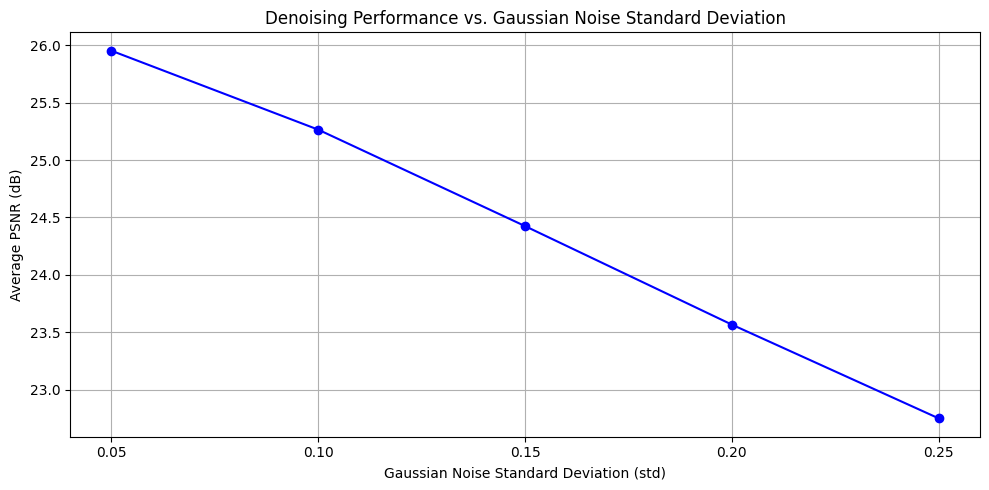

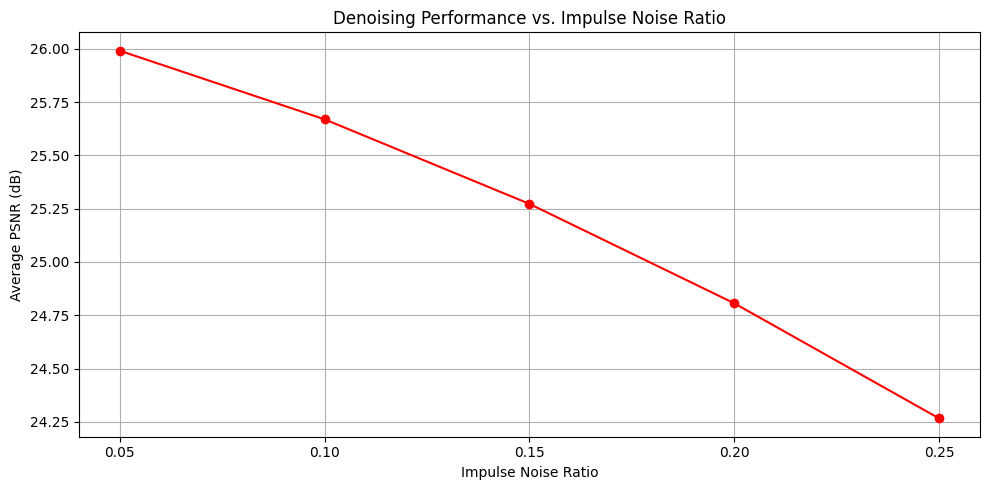

PSNR performance plots generated.


In [ ]:
import matplotlib.pyplot as plt

# Plotting Gaussian Noise PSNR
plt.figure(figsize=(10, 5))
plt.plot(gaussian_std_levels, psnr_values_gaussian, marker='o', linestyle='-', color='blue')
plt.title('Denoising Performance vs. Gaussian Noise Standard Deviation')
plt.xlabel('Gaussian Noise Standard Deviation (std)')
plt.ylabel('Average PSNR (dB)')
plt.grid(True)
plt.xticks(gaussian_std_levels) # Ensure all std levels are shown on x-axis
plt.tight_layout()
plt.show()

# Plotting Impulse Noise PSNR
plt.figure(figsize=(10, 5))
plt.plot(impulse_ratio_levels, psnr_values_impulse, marker='o', linestyle='-', color='red')
plt.title('Denoising Performance vs. Impulse Noise Ratio')
plt.xlabel('Impulse Noise Ratio')
plt.ylabel('Average PSNR (dB)')
plt.grid(True)
plt.xticks(impulse_ratio_levels) # Ensure all ratio levels are shown on x-axis
plt.tight_layout()
plt.show()

print("PSNR performance plots generated.")

### 12. Visualizing Denoising Examples

Displaying example images for Gaussian noise (highest levels)...

Gaussian Noise (std=0.25):


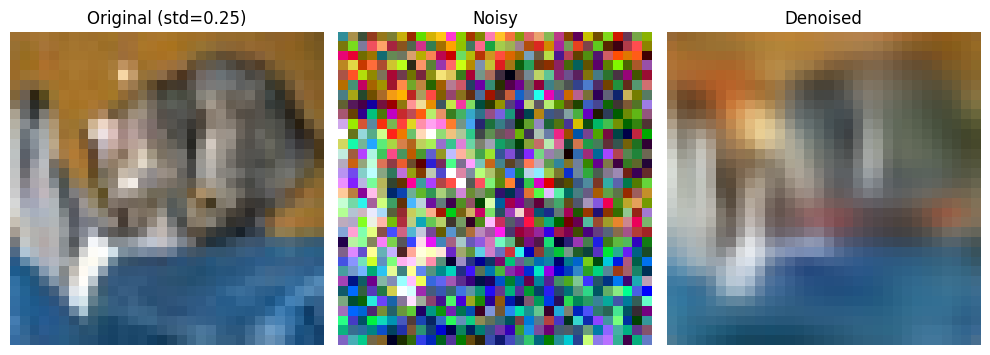


Gaussian Noise (std=0.2):


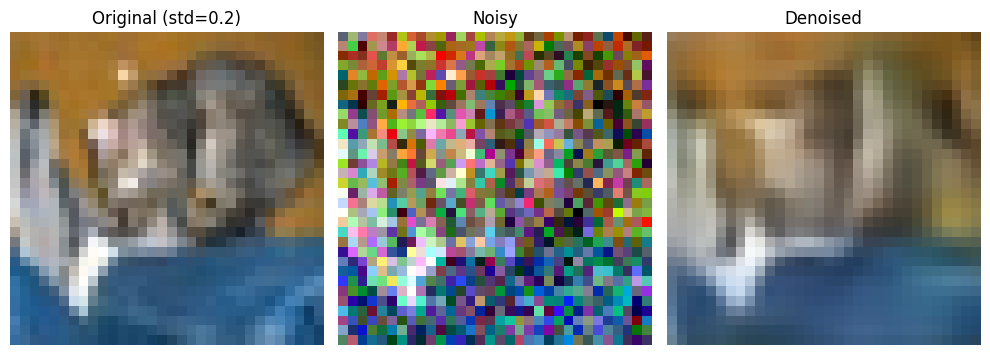


Gaussian Noise (std=0.15):


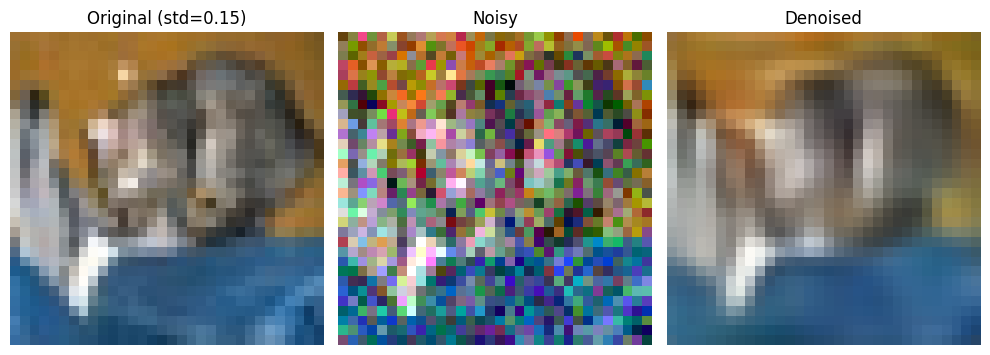


Displaying example images for Impulse noise (highest levels)...

Impulse Noise (ratio=0.25):


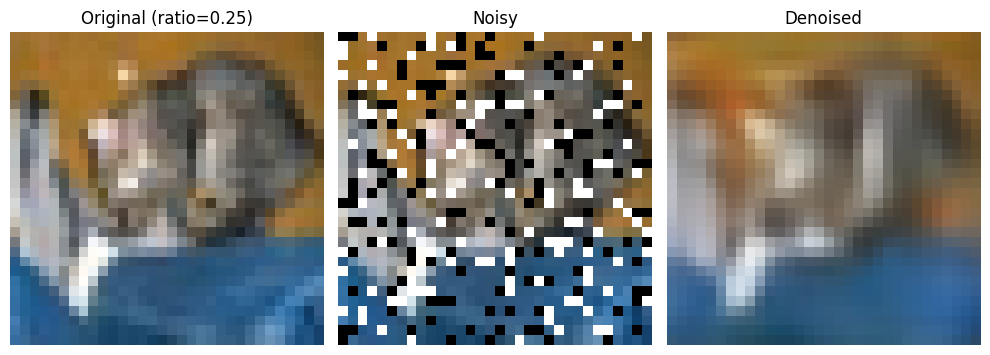


Impulse Noise (ratio=0.2):


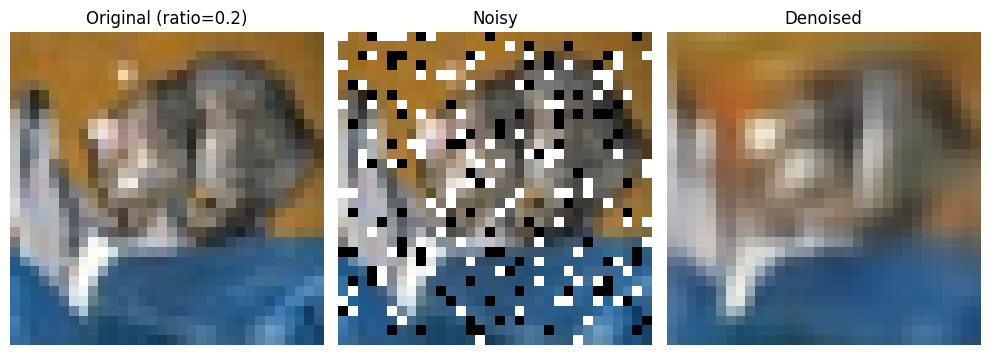


Impulse Noise (ratio=0.15):


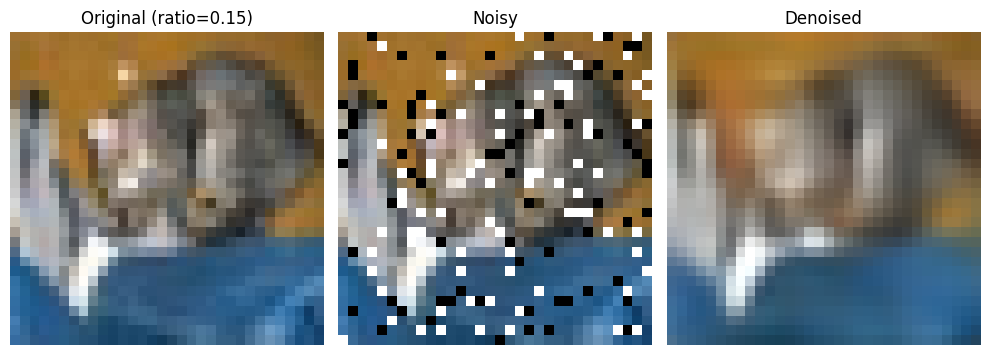

Example image display complete.


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(img, title=None):
    # Helper function to display an image tensor
    # Clamp the image to [0, 1] range to avoid clipping warnings and ensure proper display
    img = torch.clamp(img, 0., 1.)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title: plt.title(title)
    plt.axis('off')

# Set model to evaluation mode
model.eval()

num_display_images = 1 # Number of example images to display for each selected noise level

# Select higher noise levels for display
selected_gaussian_stds = sorted(gaussian_std_levels, reverse=True)[:3] # Top 3 highest stds
selected_impulse_ratios = sorted(impulse_ratio_levels, reverse=True)[:3] # Top 3 highest ratios

print("Displaying example images for Gaussian noise (highest levels)...")
for std in selected_gaussian_stds:
    dataloader = gaussian_dataloaders[std]
    print(f"\nGaussian Noise (std={std}):")
    images_shown = 0
    with torch.no_grad():
        for noisy_batch, clean_batch, _ in dataloader:
            if images_shown >= num_display_images: break

            # Take the first image from the batch
            noisy_image = noisy_batch[0].to(device)
            clean_image = clean_batch[0].to(device)

            denoised_image = model(noisy_image.unsqueeze(0)).squeeze(0) # Add/remove batch dimension

            plt.figure(figsize=(10, 4))

            plt.subplot(1, 3, 1)
            imshow(clean_image.cpu(), title=f'Original (std={std})')

            plt.subplot(1, 3, 2)
            imshow(noisy_image.cpu(), title='Noisy')

            plt.subplot(1, 3, 3)
            imshow(denoised_image.cpu(), title='Denoised')

            plt.tight_layout()
            plt.show()
            images_shown += 1

print("\nDisplaying example images for Impulse noise (highest levels)...")
for ratio in selected_impulse_ratios:
    dataloader = impulse_dataloaders[ratio]
    print(f"\nImpulse Noise (ratio={ratio}):")
    images_shown = 0
    with torch.no_grad():
        for noisy_batch, clean_batch, _ in dataloader:
            if images_shown >= num_display_images: break

            noisy_image = noisy_batch[0].to(device)
            clean_image = clean_batch[0].to(device)

            denoised_image = model(noisy_image.unsqueeze(0)).squeeze(0)

            plt.figure(figsize=(10, 4))

            plt.subplot(1, 3, 1)
            imshow(clean_image.cpu(), title=f'Original (ratio={ratio})')

            plt.subplot(1, 3, 2)
            imshow(noisy_image.cpu(), title='Noisy')

            plt.subplot(1, 3, 3)
            imshow(denoised_image.cpu(), title='Denoised')

            plt.tight_layout()
            plt.show()
            images_shown += 1

print("Example image display complete.")